In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
tf.__version__

'2.11.0'

In [ ]:
!python --version

Python 3.8.10


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import tensorflow as tf

In [ ]:
DATADIR = "/content/gdrive/MyDrive/face"
CATEGORIES = ["s1","s2","s3","s4","s8","s9"]


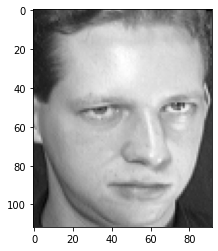

In [ ]:

for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

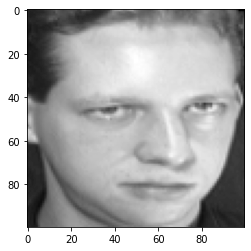

In [ ]:
IMG_SIZE = 100

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

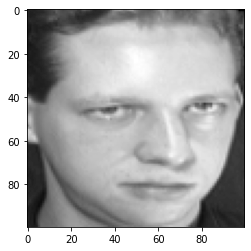

In [ ]:
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [ ]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|██████████| 11/11 [00:05<00:00,  1.88it/s]

60


In [ ]:
import random

random.shuffle(training_data)

In [ ]:
X = []
y = []

for features,label in training_data[:48]:
    X.append(features)
    y.append(label)

print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE))
Y=np.array(y)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE)

[[[110 106 108 ... 109 111 109]
  [109 107 109 ... 108 110 109]
  [108 107 109 ... 109 109 108]
  ...
  [ 71  69  64 ...  58  54  54]
  [ 71  69  62 ...  54  54  59]
  [ 68  65  61 ...  50  53  53]]]


In [ ]:
X.shape,Y.shape

((48, 100, 100), (48,))

In [ ]:
X_test = []
y_test= []

for features,label in training_data[48:]:
    X_test.append(features)
    y_test.append(label)

print(X_test[0].reshape(-1, IMG_SIZE, IMG_SIZE))
Y_test=np.array(y_test)
X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE)

[[[ 34  38  36 ...  36  35  35]
  [ 35  36  36 ...  34  35  35]
  [ 36  40  37 ...  34  37  36]
  ...
  [ 39  37  38 ...  47  37  32]
  [ 40  35  41 ... 116 112 105]
  [ 39  36  35 ... 135 138 146]]]


In [ ]:
 X_test.shape,Y_test.shape

((12, 100, 100), (12,))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_A_inp (InputLayer)         [(None, 100, 100)]   0           []                               
                                                                                                  
 img_B_inp (InputLayer)         [(None, 100, 100)]   0           []                               
                                                                                                  
 sequential_4 (Sequential)      (None, 64)           1586496     ['img_A_inp[0][0]',              
                                                                  'img_B_inp[0][0]']              
                                                                                                  
 tf.concat (TFOpLambda)         (None, 128)          0           ['sequential_4[0][0]',       

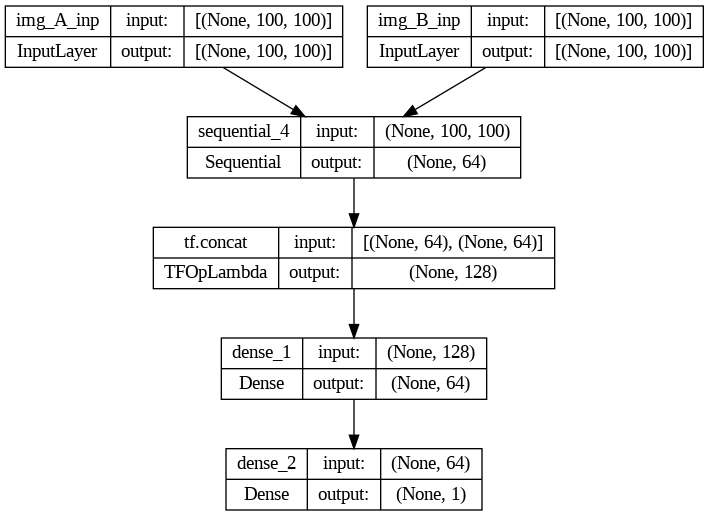

In [ ]:
from typing_extensions import Concatenate
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential,Model

img_A_inp=Input((100,100),name='img_A_inp')
img_B_inp=Input((100,100),name='img_B_inp')

def get_cnn_block(depth):
  return Sequential([Conv2D(depth,3,1),
                     BatchNormalization(),
                     ReLU()])
DEPTH=64

cnn=Sequential([Reshape((100,100,1)),
                get_cnn_block(DEPTH),
                get_cnn_block(DEPTH*2),
                get_cnn_block(DEPTH*4),
                get_cnn_block(DEPTH*8),
                GlobalAveragePooling2D(),
                Dense(64,activation='relu')
                ])
feature_vector_A=cnn(img_A_inp)
feature_vector_B=cnn(img_B_inp)

concat=tf.concat([feature_vector_A,feature_vector_B],axis=-1)

dense = Dense(64,activation='relu')(concat)

output=Dense(1,activation='sigmoid')(dense)
model=Model(inputs=[img_A_inp,img_B_inp],outputs=output)
model.summary()
keras.utils.plot_model(model, "architecture.png", show_shapes=True)

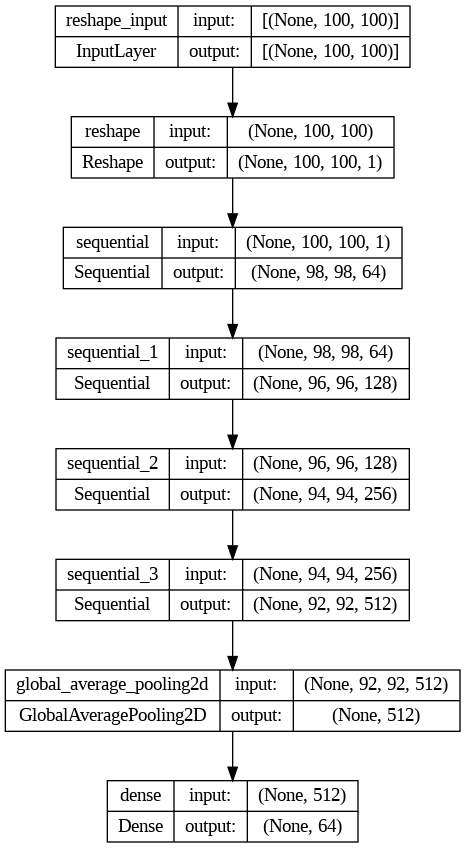

In [ ]:
from tensorflow import keras
keras.utils.plot_model(cnn, "architecture.png", show_shapes=True)

In [ ]:
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 100, 100, 1)       0         
                                                                 
 sequential (Sequential)     (None, 98, 98, 64)        896       
                                                                 
 sequential_1 (Sequential)   (None, 96, 96, 128)       74368     
                                                                 
 sequential_2 (Sequential)   (None, 94, 94, 256)       296192    
                                                                 
 sequential_3 (Sequential)   (None, 92, 92, 512)       1182208   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                      

In [ ]:
import itertools

def make_paired_dataset(X, y):
  X_pairs, y_pairs = [], []

  tuples = [(x1, y1) for x1, y1 in zip(X, y)]
  
  for t in itertools.product(tuples, tuples):
    pair_A, pair_B = t
    img_A, label_A = t[0]
    img_B, label_B = t[1]

    new_label = int(label_A == label_B)

    X_pairs.append([img_A, img_B])
    y_pairs.append(new_label)
  
  X_pairs = np.array(X_pairs)
  y_pairs = np.array(y_pairs)

  return X_pairs, y_pairs

In [ ]:
X_train_pairs, y_train_pairs = make_paired_dataset(X, Y)

X_train_pairs.shape, y_train_pairs.shape

((2304, 2, 100, 100), (2304,))

In [ ]:
X_test_pairs, y_test_pairs = make_paired_dataset(X_test, Y_test)

X_test_pairs.shape, y_test_pairs.shape

((144, 2, 100, 100), (144,))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3)

In [ ]:
model.fit(x=[X_train_pairs[:, 0, :, :], X_train_pairs[:, 1, :, :]],
          y=y_train_pairs,
          validation_data=([X_test_pairs[:, 0, :, :], 
                            X_test_pairs[:, 1, :, :]],
                           y_test_pairs),
          epochs=5,
          batch_size=32,
          callbacks=[es])

Epoch 1/5
72/72 [==============================] - 50s 699ms/step - loss: 0.0092 - accuracy: 0.9983 - val_loss: 0.0604 - val_accuracy: 0.9653
Epoch 2/5
72/72 [==============================] - 52s 724ms/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 0.1321 - val_accuracy: 0.9444
Epoch 3/5
72/72 [==============================] - 56s 780ms/step - loss: 0.0030 - accuracy: 0.9996 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 4/5
72/72 [==============================] - 56s 773ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 5/5
72/72 [==============================] - 56s 781ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1.0000


In [ ]:
img_A, img_B = X_test[0], X_test[1]
label_A, label_B = y_test[0], y_test[1]

label_A, label_B

(0, 4)

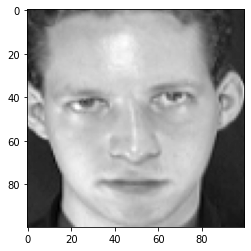

In [ ]:
new_array = cv2.resize(img_A, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

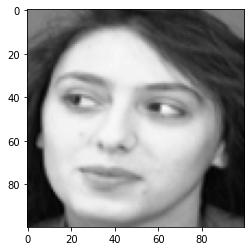

In [ ]:
new_array = cv2.resize(img_B, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [ ]:
model.predict([img_A.reshape((1, 100, 100)), 
               img_B.reshape((1, 100, 100))]).flatten()[0] > 0.5

1/1 [==============================] - 0s 20ms/step


False

In [ ]:
model.save('/content/gdrive/MyDrive/my_model.h5')

In [ ]:
new_model = tf.keras.models.load_model('/content/gdrive/MyDrive/my_model.h5')

# Show the model architecture
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_A_inp (InputLayer)         [(None, 100, 100)]   0           []                               
                                                                                                  
 img_B_inp (InputLayer)         [(None, 100, 100)]   0           []                               
                                                                                                  
 sequential_4 (Sequential)      (None, 64)           1586496     ['img_A_inp[0][0]',              
                                                                  'img_B_inp[0][0]']              
                                                                                                  
 tf.concat (TFOpLambda)         (None, 128)          0           ['sequential_4[0][0]',       

In [ ]:
new_model.predict([img_A.reshape((1, 100, 100)), 
               img_B.reshape((1, 100, 100))]).flatten()[0] > 0.5

1/1 [==============================] - 0s 174ms/step


False

In [ ]:
def get_arr_img(img):
  img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
  return cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
  

In [ ]:
img1=get_arr_img("/content/gdrive/MyDrive/face/s1/1.png")
img2=get_arr_img("/content/gdrive/MyDrive/face/s4/1.png")

In [ ]:
a=new_model.predict([img1.reshape((1, 100, 100)), 
               img2.reshape((1, 100, 100))]).flatten()[0] 
a,a>.5

1/1 [==============================] - 0s 22ms/step


(0.00039617863, False)